### Deep Ensamble MDN Toy Example ###

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_ensemble_mdn_model import EnsambleMDN

from aml_dl.gp.simple_gp import GaussianProcess, kernel

from IPython import display
import time

## Configs

In [6]:
EXP_NAME = 'exp_ensemble'

aml_data = '~/.aml_data_tmp'
check_point_dir   = aml_data + '/aml_dl/mdn/tf_check_points/exp_ensemble/'
summary_dir = aml_data + '/aml_dl/mdn/summaries/exp_ensemble/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'n_ensembles': 5,
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': [20,20,10],#[20,20,10],
    'k_mixtures': 1,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'batch_size': 128,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
    'adv_epsilon': 0.005,
    'adv_batch_size': 50
}

In [7]:
tf.set_random_seed(42)
sess = tf.InteractiveSession()

In [8]:
ensamble_mdn = EnsambleMDN(network_params,sess)

In [9]:
ensamble_mdn._init_model()

In [10]:
noise_level = 0.1#0.00000001;
width = 0.5
scale = 30
gp = GaussianProcess(noise_level, width, scale, kernel)

## Prepare data

In [11]:
def fun_h(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return np.cos(2*t - 1/2)/2 + np.cos(t) + 1 + noise

def fun_poly(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return -0.01*(t ** 3) + np.square(t)*0.01 + noise

# *
def fun_s(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    return (t-8) ** 3 - 5 * (t - 8)

def fun_c(t, noise_gain=0.0):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
        
    return t * np.cos(t) + noise

def fun_g(t, noise_gain=0.):
    if len(t.shape) > 1:
        noise = noise_gain*np.random.randn(t.shape[0],t.shape[1])
    else:
        noise = noise_gain*np.random.randn(t.shape[0])
    noise = noise_gain*np.random.randn(d1, d2)
    return np.divide(np.power(np.multiply((np.sin(t) - np.sin(2*t)/2 + np.sin(3*t)/3. - 
                                           np.sin(4*t)/4. + 4),t),2),(t+1)) + noise

def sawtoothxy(x,y):
    t, r = cart2pol(x,y) # change to polar coordinates
    h = fun_h(t)
    g = fun_g(r)
    f = np.multiply(g,h)
    return f

func_y = fun_h

In [12]:
num_data_points = 2000 # 1000
x_values = np.linspace(0, 12, num_data_points)
y_values = func_y(x_values, 0.0)

In [13]:
x_train = np.vstack([x_values[200:400,None],x_values[750:1000,None],x_values[1250:1450,None]])
y_train = np.vstack([y_values[200:400,None],y_values[750:1000,None],y_values[1250:1450,None]])

In [14]:
for idx in range(x_train.shape[0]):
    gp.update(x_train[idx,:], y_train[idx,:])

In [15]:
pred, cov, logp = gp.predict3(x_values)
std = np.sqrt(np.diagonal(cov))

In [16]:
sample_posterior = gp.sample_multivariate(pred, cov, len(pred), 5)

In [17]:
# plt.figure(figsize=(10,5))
# plt.plot(x_values, y_values,'b-',alpha=0.3)
# plt.plot(x_train, y_train,'ro',alpha=0.3)
# plt.xlim(0,12)
# plt.ylim(-6,6)
# plt.show()

(-6, 6)

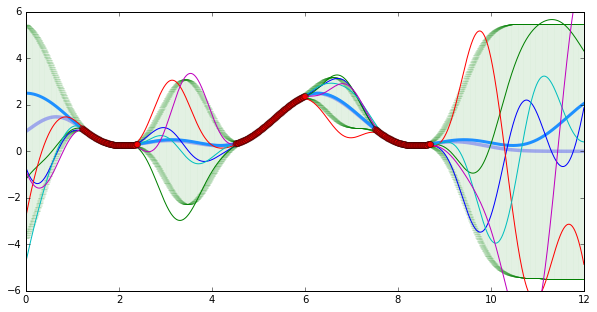

In [18]:
plt.figure(figsize=(10,5))
plt.errorbar(x_values, pred, yerr=std, fmt='b-', ecolor='g', elinewidth=0.1, linewidth=3.5,alpha=0.3)
plt.plot(x_values, y_values, 'dodgerblue', linewidth=3.0)
plt.plot(x_values, sample_posterior)
plt.plot(gp.x, gp.y, 'ro',alpha=0.3)
plt.xlim(0,12)
plt.ylim(-6,6)

## MDN

In [19]:
iterations = 5000

In [20]:
loss = ensamble_mdn.train(x_train, y_train, sess, iterations)

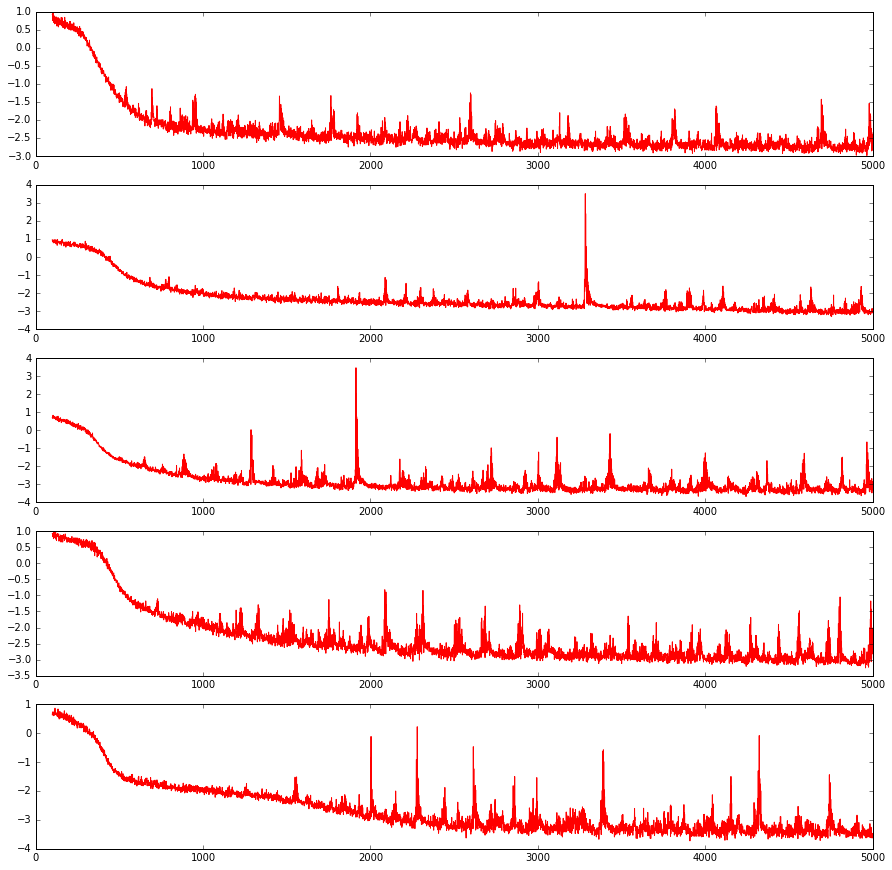

In [21]:
#plot loss curves
plt.figure(figsize=(15,15))
plot_no=network_params['n_ensembles']*100+11
for k in range(network_params['n_ensembles']):
    plt.subplot(plot_no)
    plt.plot(np.arange(100, iterations,1), loss[k, 100:], 'r-')
    plot_no += 1
plt.show()

## Test

In [22]:
x_test = np.linspace(0, 12, num_data_points)
y_test = func_y(x_test, 0.0)

In [23]:
# plt.figure(figsize=(10,5))
# plt.plot(x_test, y_test,'b-',alpha=0.3)
# plt.plot(x_train, y_train,'ro',alpha=0.3)
# plt.xlim(0,12)
# plt.ylim(-6,6)
# plt.show()

In [24]:
out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))

[ 13.61283541  13.65791642  13.70199759 ...,   0.61299752   0.61352966
   0.61406012]


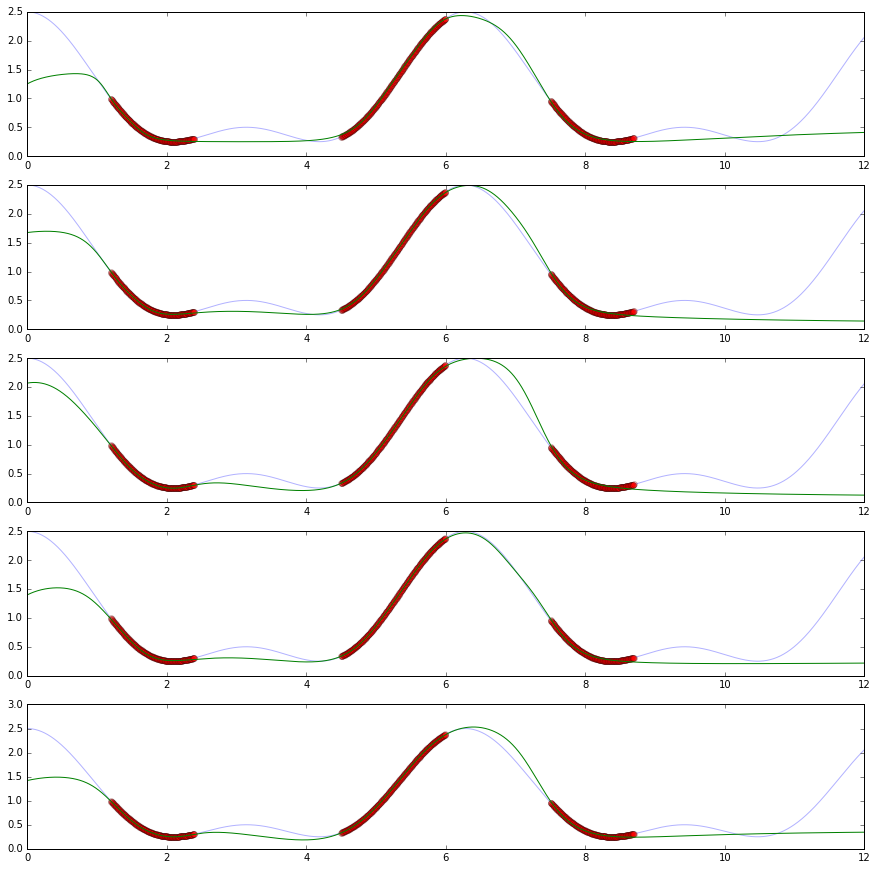

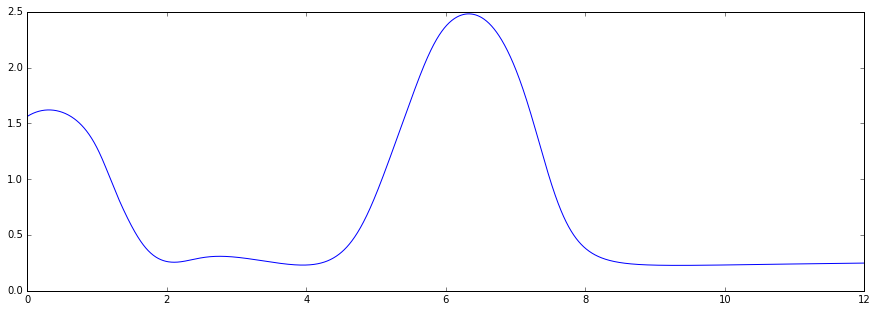

In [25]:
# #plot results, [here the results are not combined, but rather checked]
stddev = 3.

fig=plt.figure(figsize=(15,15))
plot_no=network_params['n_ensembles']*100+11

mean = np.zeros(np.reshape(out_mus[k],(-1,)).shape)
var = np.zeros(np.reshape(out_sigma[k],(-1,)).shape)
for k in range(network_params['n_ensembles']):
    pred_mu = np.reshape(out_mus[k],(-1,))
    mean += pred_mu
    var += var + np.square(pred_mu)
    pred_sigma = np.reshape(out_sigma[k],(-1,))
    ax = fig.add_subplot(plot_no)
    ax.plot(x_test, y_test,'b-',alpha=0.3)
    ax.plot(x_train, y_train,'ro',alpha=0.3)
#     ax.plot(x_test, y_test, color='r')
    
    ypl = [float(mu-stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]
    yph = [float(mu+stddev*sig) for mu,sig in zip(pred_mu,pred_sigma)]

    #ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.3)
    ax.plot(x_test, pred_mu, color='g')
    
    plot_no += 1

mean /= network_params['n_ensembles']

var -= np.square(mean)

var /= network_params['n_ensembles']

fig2 = plt.figure(figsize=(15,5))
ax = fig2.add_subplot(111)

ypl = [float(mu-stddev*np.sqrt(sig)/20) for mu,sig in zip(mean,var)]
yph = [float(mu+stddev*np.sqrt(sig)/20) for mu,sig in zip(mean,var)]

print var

#ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.3)
ax.plot(x_test, mean, color='b')
ax.set_xlim(0,12)
#ax.set_ylim(-6,6)

plt.show()

In [26]:
mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))

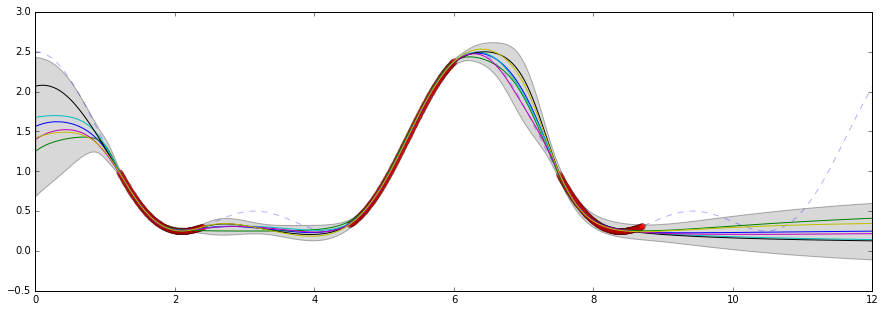

In [27]:
stddev = 3.

fig2 = plt.figure(figsize=(15,5))
ax = fig2.add_subplot(111)

ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

#ax.plot(x_test, y_test, 'ro', alpha=0.3)
ax.plot(x_test, y_test,'b--',alpha=0.3)
ax.plot(x_train, y_train,'ro',alpha=0.3)

ax.fill_between(x_test.tolist(), ypl, yph, facecolor='grey', interpolate=True, alpha=0.3)
ax.plot(x_test, mean_out, color='b')

colours = ['g','c','k','m','y']
for k in range(network_params['n_ensembles']):
     ax.plot(x_test, np.reshape(out_mus[k],(-1,)), color=colours[k])
plt.show()